In [1]:
import pandas as pd
import numpy as np
from typing import List
import statsmodels.stats.api as sms
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import yfinance as yf
import scipy.stats as stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from statsmodels.tsa.stattools import coint
import requests
from IPython.display import display
from sklearn.decomposition import PCA


In [2]:
def get_sp500_tickers(limit=None):
    """
    Tự động lấy danh sách mã S&P 500 từ Wikipedia và trả về danh sách mã cổ phiếu.

    Args: limit (int, optional): Số lượng mã cổ phiếu tối đa cần tải.

    Returns:
        tuple: (list of str) Danh sách mã cổ phiếu (Tickers),
               (pd.DataFrame) DataFrame gốc của S&P 500 (chứa các thông tin khác).
    """
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        table = pd.read_html(response.text)
        sp500_df = table[0]

        if 'Symbol' in sp500_df.columns:
            tickers = sp500_df['Symbol'].tolist()
        else:
            print("Không tìm thấy cột 'Symbol'. Vui lòng kiểm tra lại cấu trúc bảng Wikipedia.")
            return [], pd.DataFrame()

        # Số lượng cổ phiếu
        if limit is not None and isinstance(limit, int) and limit > 0:
            tickers = tickers[:limit]
            sp500_df = sp500_df.head(limit)

        tickers = [t.replace('.', '-') for t in tickers]
        print(f"Đã tải thành công danh sách {len(tickers)} mã đầu từ Wikipedia.")
        return tickers, sp500_df
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải danh sách S&P 500 từ Wikipedia: {e}")
        return [], pd.DataFrame()

In [3]:
# --- THỰC THI HÀM VÀ IN KẾT QUẢ ---
tickers_list, sp500_df = get_sp500_tickers(limit=50)
print(tickers_list)
print(sp500_df.head(5).to_markdown())

/tmp/ipython-input-688510378.py:17: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_html(response.text)


Đã tải thành công danh sách 50 mã đầu từ Wikipedia.
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APP', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK']
|    | Symbol   | Security            | GICS Sector            | GICS Sub-Industry              | Headquarters Location   | Date added   |     CIK | Founded     |
|---:|:---------|:--------------------|:-----------------------|:-------------------------------|:------------------------|:-------------|--------:|:------------|
|  0 | MMM      | 3M                  | Industrials            | Industrial Conglomerates       | Saint Paul, Minnesota   | 1957-03-04   |   66740 | 1902        |
|  1 | AOS      | A. O. Smith         | Industrials            | Building Products             

Chọn lọc:  

- Các công ty mới được thêm vào S&P 500 sau ngày START_DATE thì các công ty này, chúng sẽ có giá trị thiếu (NaN) cho các ngày START_DATE từ đến ngày IPO của chúng, dẫn đến việc phải loại bỏ các giá trị thiếu đó và làm sai lệch quá trình chuẩn hóa, PCA, và K-Means.
- Để tránh lỗi chọn lọc sống sót (survivorship bias), cần phải lọc những công ty đã có mặt trên thị trường trong suốt toàn bộ giai đoạn phân tích để đảm bảo tính đồng nhất của dữ liệu.  

      sp500_df['Date added'] < START_DATE

In [4]:
# 1. Định nghĩa ngày bắt đầu phân tích:
START_DATE = '2020-01-01'

# 2.Lọc DataFrame để chỉ giữ lại các mã đã có mặt trong chỉ số trước ngày 01-01-2020
sp500_df['Date added'] = pd.to_datetime(sp500_df['Date added'], errors='coerce')
valid_constituents = sp500_df[sp500_df['Date added'] < START_DATE]

# 3. Lấy danh sách mã cổ phiếu đã lọc
final_tickers = valid_constituents['Symbol'].tolist()

print(f"Số lượng mã hợp lệ: {len(final_tickers)}")
print(final_tickers)

Số lượng mã hợp lệ: 46
['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK']


In [5]:
def safe_fill_missing_data(data: pd.DataFrame, price_col: str) -> tuple[pd.DataFrame, int]:
    """
    Xử lý dữ liệu bị thiếu (NaN) bằng FFILL (Safer Substitution),
    và đảm bảo loại bỏ mọi NaN còn sót lại ở đầu chuỗi.

    Args:
        temp_data (pd.DataFrame): DataFrame chứa dữ liệu giá thô.
        filled_count: Tên cột chứa dữ liệu giá cần xử lý.

    Returns:
        tuple[pd.DataFrame, int]: DataFrame đã được xử lý (không còn NaN) và số lượng NaN đã điền.
    """
    temp_data = data.copy()
    missing_count_initial = temp_data[price_col].isnull().sum()

    if missing_count_initial > 0:
        temp_data[price_col] = temp_data[price_col].ffill()

    # Loại bỏ các NaN còn sót lại ở đầu chuỗi thời gian
    temp_data = temp_data.dropna(subset=[price_col])

    missing_count_final = temp_data[price_col].isnull().sum()
    filled_count = missing_count_initial - missing_count_final

    return temp_data, filled_count

In [6]:
def handle_outliers_iqr_winsorization(data_series, k=3.0):
    """
    Xử lý ngoại lai (Outliers) cho một chuỗi dữ liệu bằng phương pháp
    IQR (Interquartile Range) kết hợp với Winsorization.

    Args:
        data_series (pd.Series): Chuỗi dữ liệu đầu vào
        k (float): Hệ số nhân cho IQR

    Returns:
        pd.Series: Chuỗi dữ liệu đã được xử lý ngoại lai (Winsorized).
    """
    if data_series.empty or data_series.isnull().all():
        return pd.Series([], dtype=data_series.dtype)

    Q1 = data_series.quantile(0.25)
    Q3 = data_series.quantile(0.75)
    IQR = Q3 - Q1

    # Xử lý trường hợp IQR không xác định hoặc bằng 0
    if pd.isna(IQR) or IQR == 0:
        return data_series

    # Xác định Ngưỡng Giới hạn (Bounds) dựa trên IQR
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    # Sử dụng .clip() để đảm bảo tất cả giá trị đều bị giới hạn
    winsorized_data = np.clip(data_series, lower_bound, upper_bound)

    return pd.Series(winsorized_data, index=data_series.index)

In [7]:
def prepare_data_optimized(tickers: list, start_date='2020-01-01', end_date='2025-09-30', k_iqr=3.0):
    """
    Tải tất cả dữ liệu tất cả các cột (Open, High, Low, Close, Adjusted Close, Volume),
    xử lý thiếu (FFILL), tính lợi suất logarit, và xử lý ngoại lai bằng IQR Winsorization.

    Args:
        tickers (list): Danh sách mã cổ phiếu.
        start_date (str): Ngày bắt đầu.
        end_date (str): Ngày kết thúc.
        k_iqr (float): Hệ số nhân IQR để xác định ngưỡng Winsorization.

    Returns:
        tuple: (data_raw, log_prices, winsorized_returns_df)
            - data_raw (pd.DataFrame): Toàn bộ dữ liệu thô.
            - log_prices (pd.DataFrame): Giá logarit (chưa xử lý ngoại lai).
            - winsorized_returns_df (pd.DataFrame): Lợi suất logarit (đã xử lý ngoại lai).
    """
    # 1. Tải toàn bộ dữ liệu
    try:
        data_raw = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, actions=False, progress=False)

        if data_raw.empty:
            raise ValueError("Dữ liệu thô tải về rỗng sau khi download.")
        prices_df_candidates = pd.DataFrame()

        # Xử lý MultiIndex (Nhiều mã)
        if isinstance(data_raw.columns, pd.MultiIndex):
            if 'Close' in data_raw.columns.get_level_values(0):
                prices_df_candidates = data_raw['Close']
            else:
                raise ValueError("Không tìm thấy cấp 'Close' trong MultiIndex DataFrame.")

        # Xử lý Single Index (Một mã)
        elif 'Close' in data_raw.columns:
            prices_df_candidates = data_raw[['Close']].copy()
            if len(prices_df_candidates.columns) == 1 and prices_df_candidates.columns[0] == 'Close' and len(tickers) == 1:
                prices_df_candidates.columns = [tickers[0]]
        else:
            raise ValueError("Không tìm thấy cột 'Close' ở bất kỳ cấp độ nào.")

        # Loại bỏ các cột (mã cổ phiếu) toàn bộ là NaN
        prices_df = prices_df_candidates.dropna(axis=1, how='all')
    except Exception as e:
        print(f"Lỗi tải dữ liệu: {e}")
        raise ValueError(f"Lỗi tải dữ liệu: {e}")

    if prices_df.empty:
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    # 2. Xử lí dữ liệu bị thiếu:
    total_filled_count = 0
    processed_series_dict = {}

    for ticker in prices_df.columns:
        temp_df = prices_df[[ticker]].copy()
        processed_series, filled_count = safe_fill_missing_data(temp_df, ticker)

        if not processed_series.empty:
            processed_series_dict[ticker] = processed_series.iloc[:, 0]
            total_filled_count += filled_count

    # Nối tất cả các Series đã xử lý lại thành một DataFrame
    processed_prices = pd.concat(processed_series_dict, axis=1)
    processed_prices = processed_prices.dropna(axis=1, how='all')

    if processed_prices.empty:
        print("Cảnh báo: Không còn dữ liệu giá nào sau khi xử lý thiếu. Trả về DataFrame trống.")
        return data_raw, pd.DataFrame(), pd.DataFrame()

    print(f"\n Đã điền/loại bỏ tổng cộng {total_filled_count} giá trị thiếu.")

    # 3. Tính lợi suất logarit: log(Pt) - log(Pt-1) = log(Pt/Pt-1)
    log_prices = np.log(processed_prices)
    log_returns = log_prices.diff().dropna()
    log_returns = log_returns.dropna(axis=1, how='all')
    log_prices = log_prices.loc[log_returns.index]

    if log_returns.empty:
        print("Cảnh báo: Không còn dữ liệu lợi suất nào sau khi tính lợi suất logarit. Trả về DataFrame trống.")
        return data_raw, log_prices, pd.DataFrame()

    # 4. Xử lý ngoại lai (Outliers) bằng Winsorization trên lợi suất
    winsorized_returns_df = pd.DataFrame(index=log_returns.index)

    for col in log_returns.columns:
        processed_series = handle_outliers_iqr_winsorization(log_returns[col], k=k_iqr)
        if not processed_series.empty:
            winsorized_returns_df[col] = processed_series

    winsorized_returns_df = winsorized_returns_df.dropna(axis=1, how='all')

    if winsorized_returns_df.empty:
        print("Cảnh báo: Không còn dữ liệu lợi suất nào sau khi xử lý ngoại lai. Trả về DataFrame trống.")

    # Đồng bộ hóa Index của data_raw với lợi suất đã làm sạch cuối cùng
    data_raw = data_raw.loc[winsorized_returns_df.index]

    return data_raw, log_prices, log_returns, winsorized_returns_df

In [8]:
TICKERS = final_tickers
START_DATE = "2020-01-01"
END_DATE = '2025-09-30'
K_IQR_VALUE = 3.0

data_raw, log_prices, log_returns_raw, log_returns_clean = prepare_data_optimized(
        TICKERS,
        start_date=START_DATE,
        end_date=END_DATE,
        k_iqr=K_IQR_VALUE
)


log_returns_clean_rounded = log_returns_clean.round(8)
data_to_plot = pd.concat({
    'Lợi suất thô': log_returns_raw.stack(),
    'Lợi suất đã xử lý': log_returns_clean_rounded.stack()
}, axis=1)

# Thống kê mô tả
print(f"\nThống kê mô tả cho toàn bộ danh mục:\n")
descriptive_stats = pd.DataFrame({
    'Lợi suất Thô': data_to_plot['Lợi suất thô'].describe(),
    'Lợi suất Đã xử lý': data_to_plot['Lợi suất đã xử lý'].describe()
})
stats_to_show = descriptive_stats.loc[['count', 'mean', 'std', 'min', 'max']]
print(stats_to_show.to_string())



 Đã điền/loại bỏ tổng cộng 0 giá trị thiếu.

Thống kê mô tả cho toàn bộ danh mục:

       Lợi suất Thô  Lợi suất Đã xử lý
count  66332.000000       66332.000000
mean       0.000397           0.000486
std        0.022331           0.020257
min       -0.773593          -0.131150
max        0.299854           0.133941



--- Phân tích chi tiết cho cổ phiếu: MMM ---

Thống kê mô tả cho MMM:
       Lợi suất Thô  Lợi suất Đã xử lý
count   1442.000000        1442.000000
mean       0.000166           0.000139
std        0.018568           0.016621
min       -0.116927          -0.060764
max        0.206938           0.060949


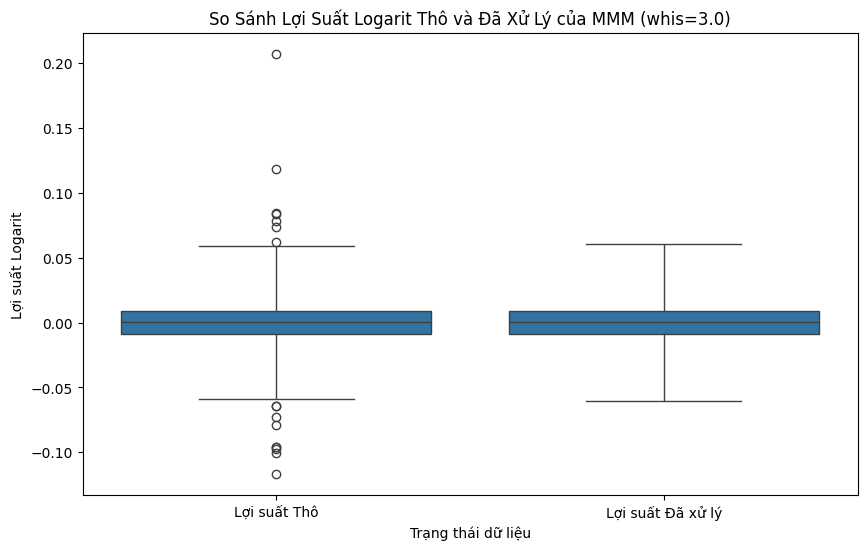


Ngưỡng Winsorization áp dụng cho dữ liệu gốc của MMM (k=3.0):
  Lower Bound: -0.060764
  Upper Bound: 0.060949

Kiểm tra lại giá trị Min/Max của dữ liệu đã xử lý với các ngưỡng này:
  Min lợi suất Đã xử lý (-0.060764) >= Lower Bound (-0.060764): True
  Max lợi suất Đã xử lý (0.060949) <= Upper Bound (0.060949): True


In [10]:
ticker_to_inspect = 'MMM' # @param {type:"string"} # Thay đổi mã cổ phiếu bạn muốn kiểm tra

if ticker_to_inspect not in log_returns_raw.columns:
    print(f"Mã cổ phiếu '{ticker_to_inspect}' không có trong dữ liệu.")
else:
    raw_returns_single = log_returns_raw[ticker_to_inspect]
    clean_returns_single = log_returns_clean[ticker_to_inspect]

    print(f"\n--- Phân tích chi tiết cho cổ phiếu: {ticker_to_inspect} ---")

    # Thống kê mô tả cho mã cổ phiếu đơn lẻ
    descriptive_stats_single = pd.DataFrame({
        'Lợi suất Thô': raw_returns_single.describe(),
        'Lợi suất Đã xử lý': clean_returns_single.describe()
    })
    print(f"\nThống kê mô tả cho {ticker_to_inspect}:")
    print(descriptive_stats_single.loc[['count', 'mean', 'std', 'min', 'max']].to_string())

    # Chuẩn bị dữ liệu để vẽ Box Plot cho mã cổ phiếu đơn lẻ
    data_to_plot_single = pd.DataFrame({
        'Lợi suất Thô': raw_returns_single,
        'Lợi suất Đã xử lý': clean_returns_single
    }).melt(var_name='Trạng thái dữ liệu', value_name='Lợi suất Logarit')

    # Box Plot cho mã cổ phiếu đơn lẻ
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Trạng thái dữ liệu', y='Lợi suất Logarit', data=data_to_plot_single, whis=K_IQR_VALUE)
    plt.title(f'So Sánh Lợi Suất Logarit Thô và Đã Xử Lý của {ticker_to_inspect} (whis={K_IQR_VALUE})')
    plt.ylabel('Lợi suất Logarit')
    plt.show()

    # Kiểm tra lại các ngưỡng để xác nhận
    Q1_raw = raw_returns_single.quantile(0.25)
    Q3_raw = raw_returns_single.quantile(0.75)
    IQR_raw = Q3_raw - Q1_raw

    lower_bound_winsorization = Q1_raw - K_IQR_VALUE * IQR_raw
    upper_bound_winsorization = Q3_raw + K_IQR_VALUE * IQR_raw

    print(f"\nNgưỡng Winsorization áp dụng cho dữ liệu gốc của {ticker_to_inspect} (k={K_IQR_VALUE}):")
    print(f"  Lower Bound: {lower_bound_winsorization:.6f}")
    print(f"  Upper Bound: {upper_bound_winsorization:.6f}")
    print(f"\nKiểm tra lại giá trị Min/Max của dữ liệu đã xử lý với các ngưỡng này:")
    print(f"  Min lợi suất Đã xử lý ({clean_returns_single.min():.6f}) >= Lower Bound ({lower_bound_winsorization:.6f}): {clean_returns_single.min() >= lower_bound_winsorization}")
    print(f"  Max lợi suất Đã xử lý ({clean_returns_single.max():.6f}) <= Upper Bound ({upper_bound_winsorization:.6f}): {clean_returns_single.max() <= upper_bound_winsorization}")

**Phân cụm:**  
- Sử dụng K-Means trên lợi suất cổ phiếu đã chuẩn hóa nhằm nhóm các cổ phiếu có hành vi biến động (được tóm tắt qua PCA) tương tự nhau vào cùng một cụm.  
Trực quan hóa Phương pháp Elbow để xác định K tối ưu:  
- Inertia (Tổng bình phương khoảng cách): Là tổng bình phương khoảng cách từ mỗi điểm đến tâm cụm gần nhất của nó. Mục tiêu của K-Means là giảm thiểu inertia.  
- Elbow Point(Diểm uốn): K tối ưu thường là điểm trên biểu đồ mà tốc độ giảm inertia bắt đầu chậm lại đáng kể, tạo thành một 'khuỷu tay' (elbow)

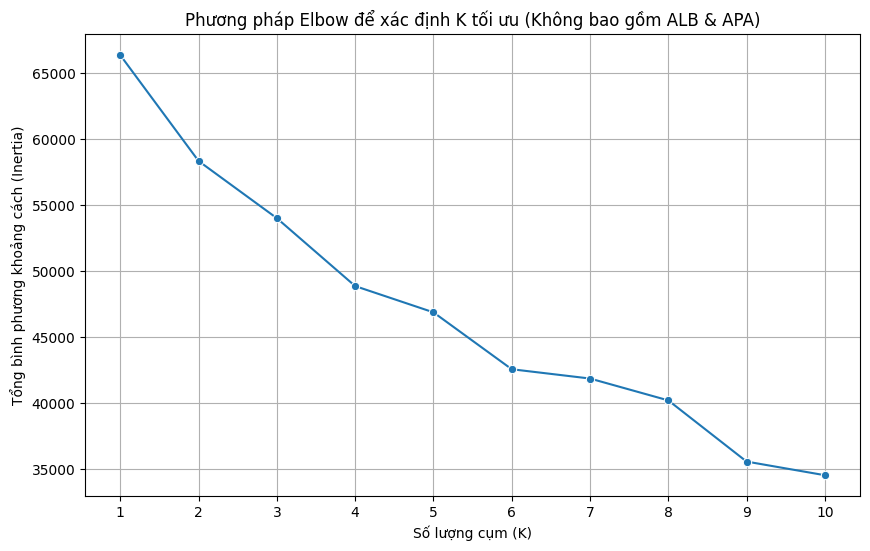

In [11]:
X = log_returns_clean.T

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

inertia = []
K_range = range(1, 11) # Thử nghiệm với K từ 1 đến 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init để tránh lỗi khởi tạo
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Vẽ biểu đồ Elbow
plt.figure(figsize=(10, 6))
sns.lineplot(x=K_range, y=inertia, marker='o', linestyle='-')
plt.title('Phương pháp Elbow để xác định K tối ưu (Không bao gồm ALB & APA)')
plt.xlabel('Số lượng cụm (K)')
plt.ylabel('Tổng bình phương khoảng cách (Inertia)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Quan sát biểu đồ:

- Từ K=1 đến K=2, Inertia giảm rất mạnh.  
- Từ K=2 đến K=3, Inertia tiếp tục giảm đáng kể.  
- Từ K=3 đến K=4, Inertia vẫn giảm, nhưng tốc độ giảm bắt đầu chậm lại.  
- Từ K=4 trở đi (K=5, K=6, v.v.), đường cong trở nên phẳng hơn, cho thấy việc tăng K không còn hiệu quả nhiều nữa.   

=> Do đó: K = 4 có vẻ là lựa chọn phù hợp nhất cho số lượng cụm tối ưu,


Số cụm tối ưu được chọn: 5

Phân bố các mã cổ phiếu trong 5 cụm:
|   Cluster |   count |
|----------:|--------:|
|         0 |       4 |
|         1 |      27 |
|         2 |       1 |
|         3 |       1 |
|         4 |      13 |


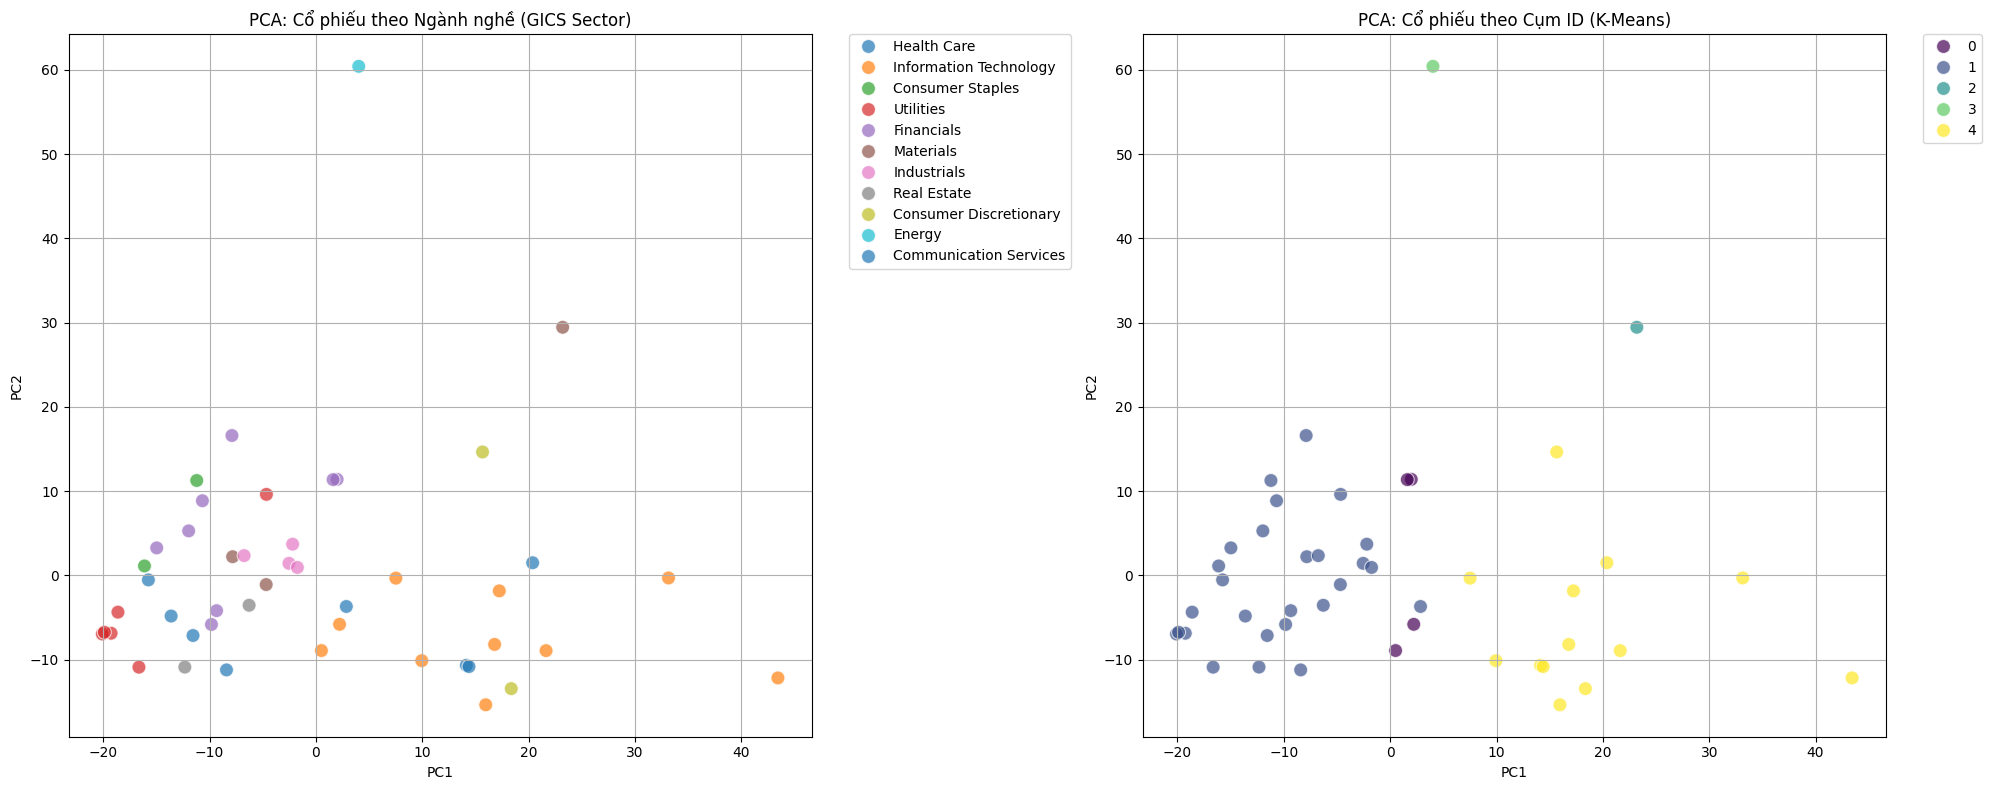


Các mã cổ phiếu trong mỗi cụm:

Cụm 0:
['ACN', 'AKAM', 'AMP', 'AXP']

Cụm 1:
['A', 'ABBV', 'ABT', 'ADM', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'ALL', 'ALLE', 'AMCR', 'AME', 'AMGN', 'AMT', 'AON', 'AOS', 'APD', 'ARE', 'ATO', 'AWK', 'LNT', 'MMM', 'MO', 'T']

Cụm 2:
['ALB']

Cụm 3:
['APA']

Cụm 4:
['AAPL', 'ADBE', 'ADI', 'ADSK', 'ALGN', 'AMAT', 'AMD', 'AMZN', 'ANET', 'APH', 'APTV', 'GOOG', 'GOOGL']


In [12]:
K_optimal = 5
print(f"\nSố cụm tối ưu được chọn: {K_optimal}")

# --- 1. CHẠY K-MEANS ---
kmeans = KMeans(n_clusters=K_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# --- 2. CHẠY PCA CHỈ MỘT LẦN ---
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=X.index)
pca_df['Cluster'] = clusters # Gán kết quả cụm

X_scaled_df['Cluster'] = clusters
cluster_results = pd.DataFrame({'Ticker': X.index, 'Cluster': clusters})

print(f"\nPhân bố các mã cổ phiếu trong {K_optimal} cụm:")
print(cluster_results['Cluster'].value_counts().sort_index().to_markdown())

# --- 3. HỢP NHẤT DỮ LIỆU ĐỂ TRỰC QUAN HÓA ---
# Hợp nhất pca_df (PC1, PC2, Cluster) với sp500_df (Sector)
pca_df_with_info = pca_df.merge(
    sp500_df[['Symbol', 'GICS Sector', 'Security']],
    left_index=True,
    right_on='Symbol',
    how='left'
)

# Đặt chỉ mục lại bằng Tickers
pca_df_with_info = pca_df_with_info.set_index(pca_df.index)

# Xử lý giá trị thiếu (NaN)
pca_df_with_info['GICS Sector'] = pca_df_with_info['GICS Sector'].fillna('Unknown')
pca_df_with_info['Security'] = pca_df_with_info['Security'].fillna('Unknown')

# --- 4. TRỰC QUAN HÓA: PLOT 1 VÀ PLOT 2 ---
plt.figure(figsize=(20, 8))

# Plot 1: Color by GICS Sector
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='GICS Sector',
    data=pca_df_with_info,
    palette='tab10',
    s=100,
    alpha=0.7,
    legend='full'
)
plt.title('PCA: Cổ phiếu theo Ngành nghề (GICS Sector)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot 2: Color by Cluster ID
plt.subplot(1, 2, 2)
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=pca_df_with_info, # Sử dụng cùng một DataFrame đã hợp nhất
    palette='viridis',
    s=100,
    alpha=0.7,
    legend='full'
)
plt.title('PCA: Cổ phiếu theo Cụm ID (K-Means)')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

# --- 5. IN DANH SÁCH CÁC MÃ CỔ PHIẾU TRONG MỖI CỤM ---
print("\nCác mã cổ phiếu trong mỗi cụm:")
for i in range(K_optimal):
    print(f"\nCụm {i}:")
    tickers_in_cluster = cluster_results[cluster_results['Cluster'] == i]['Ticker'].tolist()
    print(tickers_in_cluster)

### Bước 1: Xác định các cặp tiềm năng trong mỗi cụm

In [13]:
potential_pairs = {}

# Lặp qua từng cụm
for cluster_id in sorted(cluster_results['Cluster'].unique()):
    tickers_in_cluster = cluster_results[cluster_results['Cluster'] == cluster_id]['Ticker'].tolist()

    if len(tickers_in_cluster) > 1:
        # Tạo tất cả các cặp có thể có trong cụm
        cluster_pairs = list(combinations(tickers_in_cluster, 2))
        # Lưu trữ kết quả vào dictionary
        potential_pairs[cluster_id] = cluster_pairs
        print(f"Cụm {cluster_id}: {cluster_pairs}")
    else:
        print(f"Cụm {cluster_id} chỉ có một mã ({tickers_in_cluster[0]}), không thể ghép cặp.")


print("\nTổng hợp các cặp tiềm năng từ tất cả các cụm:")
for cluster_id, pairs in potential_pairs.items():
    print(f"  Cụm {cluster_id}: {len(pairs)} cặp")

Cụm 0: [('ACN', 'AKAM'), ('ACN', 'AMP'), ('ACN', 'AXP'), ('AKAM', 'AMP'), ('AKAM', 'AXP'), ('AMP', 'AXP')]
Cụm 1: [('A', 'ABBV'), ('A', 'ABT'), ('A', 'ADM'), ('A', 'AEE'), ('A', 'AEP'), ('A', 'AES'), ('A', 'AFL'), ('A', 'AIG'), ('A', 'AIZ'), ('A', 'AJG'), ('A', 'ALL'), ('A', 'ALLE'), ('A', 'AMCR'), ('A', 'AME'), ('A', 'AMGN'), ('A', 'AMT'), ('A', 'AON'), ('A', 'AOS'), ('A', 'APD'), ('A', 'ARE'), ('A', 'ATO'), ('A', 'AWK'), ('A', 'LNT'), ('A', 'MMM'), ('A', 'MO'), ('A', 'T'), ('ABBV', 'ABT'), ('ABBV', 'ADM'), ('ABBV', 'AEE'), ('ABBV', 'AEP'), ('ABBV', 'AES'), ('ABBV', 'AFL'), ('ABBV', 'AIG'), ('ABBV', 'AIZ'), ('ABBV', 'AJG'), ('ABBV', 'ALL'), ('ABBV', 'ALLE'), ('ABBV', 'AMCR'), ('ABBV', 'AME'), ('ABBV', 'AMGN'), ('ABBV', 'AMT'), ('ABBV', 'AON'), ('ABBV', 'AOS'), ('ABBV', 'APD'), ('ABBV', 'ARE'), ('ABBV', 'ATO'), ('ABBV', 'AWK'), ('ABBV', 'LNT'), ('ABBV', 'MMM'), ('ABBV', 'MO'), ('ABBV', 'T'), ('ABT', 'ADM'), ('ABT', 'AEE'), ('ABT', 'AEP'), ('ABT', 'AES'), ('ABT', 'AFL'), ('ABT', 'AIG'),

### Bước 2: Kiểm định tính đồng tích hợp (Cointegration)
Kiểm định đồng tích hợp giúp chúng ta xác định xem hai chuỗi thời gian có mối quan hệ cân bằng dài hạn hay không. Điều này rất quan trọng cho pair trading.  
*   **p-value:** Giá trị p-value thấp (thường < 0.05 hoặc < 0.01) cho thấy bạn có thể bác bỏ giả thuyết null rằng không có mối quan hệ đồng tích hợp. Nói cách khác, p-value càng nhỏ, khả năng hai chuỗi thời gian có mối quan hệ cân bằng dài hạn càng cao.

In [14]:
def run_cointegration_test(potential_pairs, log_prices, p_value_threshold=0.05):
    """
    Thực hiện kiểm định Đồng Tích Hợp (Engle-Granger) cho tất cả các cặp tiềm năng.

    Args:
        potential_pairs (dict): Dictionary chứa các cặp tiềm năng (Key: Cluster ID, Value: List of pairs).
        log_prices (pd.DataFrame): DataFrame chứa giá logarit (Tickers là cột).
        p_value_threshold (float): Ngưỡng p-value để chấp nhận Đồng Tích Hợp.

    Returns:
        pd.DataFrame: DataFrame chứa kết quả của tất cả các cặp Đồng Tích Hợp tìm được.
    """
    all_cointegrated_results = []
    min_data_points = 50 # Yêu cầu tối thiểu 50 điểm dữ liệu

    print(f"\n--- BẮT ĐẦU KIỂM ĐỊNH ĐỒNG TÍCH HỢP (Engle-Granger) ---")
    print(f"Ngưỡng P-value: < {p_value_threshold}")

    for cluster_id, pairs in potential_pairs.items():
        # Lặp qua từng cặp trong cụm
        for pair in pairs:
            ticker1, ticker2 = pair

            # Kiểm tra dữ liệu
            if ticker1 in log_prices.columns and ticker2 in log_prices.columns:
                series1 = log_prices[ticker1].dropna()
                series2 = log_prices[ticker2].dropna()

                common_index = series1.index.intersection(series2.index)

                if len(common_index) >= min_data_points:
                    try:
                        _, p_value, _ = coint(series1.loc[common_index], series2.loc[common_index])

                        if p_value < p_value_threshold:
                            # Thêm vào danh sách kết quả
                            all_cointegrated_results.append({
                                'Cluster': cluster_id,
                                'Pair': f"{ticker1}_{ticker2}",
                                'Ticker1': ticker1,
                                'Ticker2': ticker2,
                                'P_value': p_value,
                                'Cointegrated': True
                            })

                    except ValueError as e:
                        print(f"  Lỗi khi kiểm định cặp {pair}: {e}")
                        pass
    # Tạo DataFrame kết quả
    if all_cointegrated_results:
        results_df = pd.DataFrame(all_cointegrated_results)
        # Sắp xếp theo P-value
        results_df = results_df.sort_values(by='P_value').reset_index(drop=True)
        return results_df
    else:
        print("\nKhông tìm thấy cặp đồng tích hợp nào trong tất cả các cụm.")
        return pd.DataFrame()

In [15]:
final_cointegrated_pairs = run_cointegration_test(potential_pairs, log_prices, p_value_threshold=0.05)

if not final_cointegrated_pairs.empty:
    print(f"\nĐã tìm thấy tổng cộng {len(final_cointegrated_pairs)} cặp đồng tích hợp.")
    print("\n --- KẾT QUẢ CÁC CẶP ĐỒNG TÍCH HỢP ---")
    print(final_cointegrated_pairs.to_markdown(index=False))
else:
    print("Không tìm thấy cặp đồng tích hợp nào trong tất cả các cụm.")


--- BẮT ĐẦU KIỂM ĐỊNH ĐỒNG TÍCH HỢP (Engle-Granger) ---
Ngưỡng P-value: < 0.05

Đã tìm thấy tổng cộng 22 cặp đồng tích hợp.

 --- KẾT QUẢ CÁC CẶP ĐỒNG TÍCH HỢP ---
|   Cluster | Pair       | Ticker1   | Ticker2   |     P_value | Cointegrated   |
|----------:|:-----------|:----------|:----------|------------:|:---------------|
|         1 | AFL_AJG    | AFL       | AJG       | 0.000209852 | True           |
|         1 | AIG_AJG    | AIG       | AJG       | 0.00258895  | True           |
|         1 | LNT_MO     | LNT       | MO        | 0.00282296  | True           |
|         1 | AEP_MO     | AEP       | MO        | 0.00391261  | True           |
|         1 | ABBV_AFL   | ABBV      | AFL       | 0.00464836  | True           |
|         4 | GOOG_GOOGL | GOOG      | GOOGL     | 0.00896674  | True           |
|         4 | AAPL_ADI   | AAPL      | ADI       | 0.0102884   | True           |
|         1 | APD_MO     | APD       | MO        | 0.0126312   | True           |
|         1 | A

### Ước lượng các tham số hồi quy của tất cả các cặp đồng tích hợp

In [16]:
def calculate_spread_parameters(cointegrated_pairs_df, log_prices):
    """
    Tính toán Hedge Ratio (Beta), Alpha, và Trung bình Spread cho tất cả các cặp
    đã được xác nhận Đồng Tích Hợp.

    Args:
        cointegrated_pairs_df (pd.DataFrame): DataFrame chứa các cặp đã vượt qua kiểm định coint.
        log_prices (pd.DataFrame): DataFrame chứa giá logarit.

    Returns:
        pd.DataFrame: DataFrame mới với các cột Beta, Alpha, và Spread_Mean.
    """
    results_list = []

    # Lặp qua từng cặp trong DataFrame đã lọc
    for index, row in cointegrated_pairs_df.iterrows():
        ticker1 = row['Ticker1']
        ticker2 = row['Ticker2']

        # 1. Chuẩn bị dữ liệu
        series1 = log_prices[ticker1].dropna()
        series2 = log_prices[ticker2].dropna()

        # Đồng bộ hóa chỉ số
        common_index = series1.index.intersection(series2.index)
        series1_synced = series1.loc[common_index]
        series2_synced = series2.loc[common_index]

        # Đảm bảo có đủ dữ liệu
        if len(common_index) < 50:
            continue

        try:
            # 2. Ước lượng OLS để tìm Beta và Alpha
            # X là Ticker2 (biến độc lập), Y là Ticker1 (biến phụ thuộc)
            X = sm.add_constant(series2_synced)
            model = sm.OLS(series1_synced, X)
            results = model.fit()

            beta = results.params[ticker2]
            alpha = results.params['const']

            # 3. Tính Spread và Trung bình Spread (phần dư)
            spread = series1_synced - beta * series2_synced - alpha
            spread_mean = spread.mean()

            # 4. Lưu trữ kết quả (kết hợp với dữ liệu gốc)
            row_data = row.to_dict()
            row_data['Beta'] = beta
            row_data['Alpha'] = alpha
            row_data['Spread_Mean'] = spread_mean

            results_list.append(row_data)

        except Exception as e:
            # Bắt lỗi nếu hồi quy không thành công
            print(f"Lỗi tính toán tham số cho cặp {ticker1}/{ticker2}: {e}")
            continue

    # 5. Tạo DataFrame mới với tất cả các thông số
    final_params_df = pd.DataFrame(results_list)
    # Giữ lại các cột quan trọng nhất và sắp xếp lại
    final_params_df = final_params_df[['Cluster', 'Pair', 'Ticker1', 'Ticker2', 'P_value', 'Beta', 'Alpha', 'Spread_Mean']]

    return final_params_df

In [17]:
if 'final_cointegrated_pairs' in locals() and not final_cointegrated_pairs.empty:

    # Gọi hàm thực thi
    final_analysis_df = calculate_spread_parameters(final_cointegrated_pairs, log_prices)

    print("\n KẾT QUẢ CÁC THAM SỐ HỒI QUY CỦA TẤT CẢ CẶP ĐỒNG TÍCH HỢP:")
    # In ra dưới dạng bảng
    print(final_analysis_df.to_markdown(index=False, floatfmt=".4f"))

else:
    print("Không tìm thấy cặp Đồng Tích Hợp nào để tính toán tham số.")


 KẾT QUẢ CÁC THAM SỐ HỒI QUY CỦA TẤT CẢ CẶP ĐỒNG TÍCH HỢP:
|   Cluster | Pair       | Ticker1   | Ticker2   |   P_value |    Beta |   Alpha |   Spread_Mean |
|----------:|:-----------|:----------|:----------|----------:|--------:|--------:|--------------:|
|         1 | AFL_AJG    | AFL       | AJG       |    0.0002 |  0.9130 | -0.6130 |       -0.0000 |
|         1 | AIG_AJG    | AIG       | AJG       |    0.0026 |  0.8045 | -0.2156 |        0.0000 |
|         1 | LNT_MO     | LNT       | MO        |    0.0028 |  0.4468 |  2.2972 |        0.0000 |
|         1 | AEP_MO     | AEP       | MO        |    0.0039 |  0.5262 |  2.4837 |        0.0000 |
|         1 | ABBV_AFL   | ABBV      | AFL       |    0.0046 |  0.8223 |  1.4313 |       -0.0000 |
|         4 | GOOG_GOOGL | GOOG      | GOOGL     |    0.0090 |  1.0057 | -0.0209 |        0.0000 |
|         4 | AAPL_ADI   | AAPL      | ADI       |    0.0103 |  1.1923 | -1.0310 |        0.0000 |
|         1 | APD_MO     | APD       | MO        

### Kiểm tra phương sai đồng nhất và phân phối chuẩn của Spread

In [18]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis

def check_normality_and_homoscedasticity_flexible(data_series, exogenous_vars=None, data_type="Spread"):
    """
    Thực hiện Kiểm định Jarque-Bera (Normality) và Kiểm định Phương sai
    linh hoạt (BP cho Spread thô, ARCH-LM cho GARCH Z-Score).

    Args:
        data_series (pd.Series): Chuỗi Spread thô hoặc GARCH Z-Score.
        exogenous_vars (pd.DataFrame, optional): Các biến ngoại sinh cho kiểm định BP.
        data_type (str): "Spread" (dùng BP) hoặc "Z-Score" (dùng ARCH-LM).

    Returns:
        tuple: (jb_p_value, skewness, kurtosis, p_value_homoscedasticity)
    """
    jb_p_value = np.nan
    skewness = np.nan
    kurtosis_value = np.nan # Đổi tên biến để tránh trùng lặp
    p_value_homoscedasticity = np.nan

    spread_cleaned = data_series.dropna()
    # THÊM KIỂM TRA NÀY: Loại bỏ các giá trị không hữu hạn (Inf)
    spread_cleaned = spread_cleaned[np.isfinite(spread_cleaned)]

    if len(spread_cleaned) > 10: # Đảm bảo có đủ quan sát để kiểm định

        # 1. KIỂM ĐỊNH JARQUE-BERA (Normality)
        try:
            jb_test_result = jarque_bera(spread_cleaned)
            jb_p_value = jb_test_result[1]
            skewness = skew(spread_cleaned)
            # Dùng fisher=False để kurtosis của phân phối chuẩn là 3.0 (Kurtosis Thô)
            kurtosis_value = kurtosis(spread_cleaned, fisher=False)
        except Exception as e:
            # print(f"Lỗi JB: {e}")
            pass

        # 2. KIỂM ĐỊNH PHƯƠNG SAI ĐỒNG NHẤT
        if data_type == "Z-Score":
            # Dùng ARCH-LM (Ljung-Box trên Z-Score^2)
            try:
                # Cần ít nhất 10 quan sát. lags=[10]
                lb_test_result = acorr_ljungbox(spread_cleaned**2, lags=[10], method='boxcar', return_df=True)
                p_value_homoscedasticity = lb_test_result.loc[10, 'lb_pvalue']
            except Exception as e:
                # print(f"Lỗi ARCH-LM: {e}")
                pass

        elif data_type == "Spread" and exogenous_vars is not None:
            # Dùng Breusch-Pagan cho Spread thô
            # Cần đảm bảo exogenous_vars được đồng bộ và không có NaN
            exog_clean = exogenous_vars.loc[spread_cleaned.index]
            exog_clean = exog_clean.dropna()

            # Đảm bảo kích thước dữ liệu khớp
            if len(exog_clean) == len(spread_cleaned) and exog_clean.shape[1] >= 2:
                try:
                     bp_test_result = sms.het_breuschpagan(spread_cleaned, exog_clean)
                     p_value_homoscedasticity = bp_test_result[1]
                except Exception as e:
                    # print(f"Lỗi BP: {e}")
                    pass

    return jb_p_value, skewness, kurtosis_value, p_value_homoscedasticity



def plot_spread_diagnostics(spread_series, pair_name, fitted_values=None):

    """
    Trực quan hóa biểu đồ chẩn đoán: Phân phối Chuẩn và Phương sai Đồng nhất.

    Args:
        spread_series (pd.Series): Chuỗi Spread (Residuals).
        pair_name (str): Tên cặp cổ phiếu.
        exogenous_vars (pd.DataFrame, optional): Các biến độc lập (exogenous variables)
                                                 từ mô hình gốc để vẽ biểu đồ Fitted vs Residuals.

    """
    print(f"\n--- TRỰC QUAN HÓA CHẤT LƯỢNG MÔ HÌNH CỦA CẶP: {pair_name} ---\n")
    spread_cleaned = spread_series.dropna()
    plt.figure(figsize=(18, 6))

    # 1. Histogram (Kiểm tra Phân phối chuẩn)

    plt.subplot(1, 3, 1)
    sns.histplot(spread_cleaned, kde=True, bins=30)
    plt.title(f'1. Histogram Spread ({pair_name})')
    plt.xlabel('Spread')


    # 2. Q-Q Plot (Kiểm tra Phân phối chuẩn)
    plt.subplot(1, 3, 2)
    stats.probplot(spread_cleaned, dist="norm", plot=plt)
    plt.title(f'2. Q-Q Plot ({pair_name})')

# 3. Residuals vs. Fitted Values
    if fitted_values is not None and len(fitted_values) == len(spread_cleaned):
        plt.subplot(1, 3, 3)
        # Sử dụng Fitted Values cho trục X (Như OLS truyền thống)
        plt.scatter(fitted_values.loc[spread_cleaned.index], spread_cleaned)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'3. Residuals vs. Fitted Values ({pair_name})')
        plt.xlabel('Fitted Values (Giá trị Ước lượng)')
        plt.ylabel('Residuals (Spread)')
    else:
        # Trường hợp không có Fitted Values (Ví dụ: sau KF)
        plt.subplot(1, 3, 3)
        plt.plot(spread_cleaned.index, spread_cleaned.values, alpha=0.8)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'3. Spread Over Time ({pair_name})')
        plt.xlabel('Date')
        plt.ylabel('Spread')

    plt.tight_layout()
    plt.show()


--- KẾT QUẢ KIỂM TRA CHẤT LƯỢNG THỐNG KÊ CỦA SPREAD ---

| Pair       |   JB_P_value | Is_Normal   |   BP_P_value | Is_Homoscedastic   |   Skewness |   Kurtosis |
|:-----------|-------------:|:------------|-------------:|:-------------------|-----------:|-----------:|
| ADSK_AMZN  |       0.4951 | True        |       0.0653 | True               |     0.0731 |     2.9548 |
| ARE_ATO    |       0.0788 | True        |       0.0001 | False              |     0.0227 |     3.2873 |
| AIG_AME    |       0.0195 | False       |       0.0000 | False              |     0.1426 |     2.7769 |
| ABT_MO     |       0.0093 | False       |       0.0000 | False              |    -0.0659 |     3.3720 |
| AIG_AON    |       0.0000 | False       |       0.0000 | False              |     0.2733 |     3.1777 |
| LNT_MO     |       0.0000 | False       |       0.0000 | False              |     0.2625 |     2.7587 |
| AWK_MMM    |       0.0000 | False       |       0.5711 | True               |    -0.3147 |  

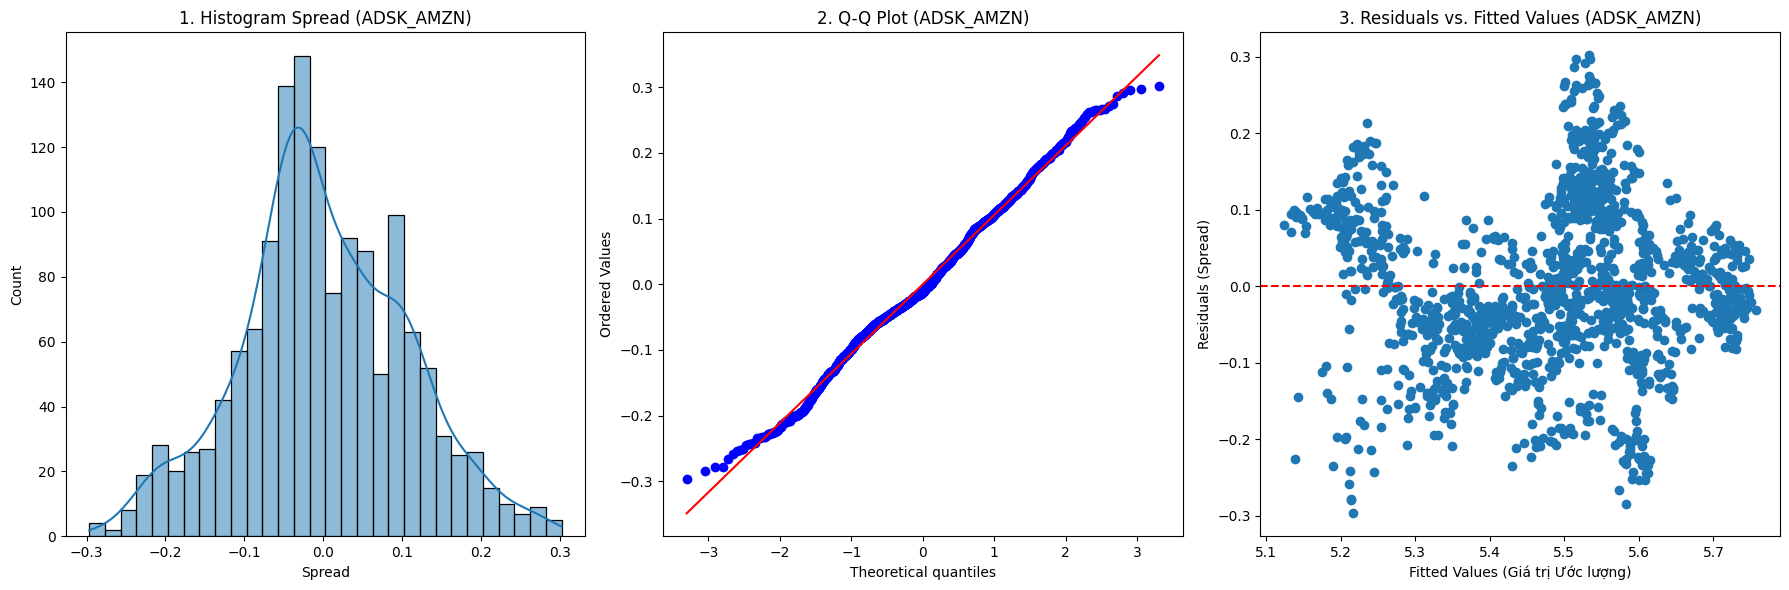

In [19]:
if 'final_analysis_df' in locals() and not final_analysis_df.empty:

    # Khởi tạo danh sách để lưu trữ kết quả kiểm định
    jb_p_values = []
    skewness_list = []
    kurtosis_list = []
    bp_p_values = []

    # Lặp qua từng cặp trong DataFrame đã lọc
    for index, row in final_analysis_df.iterrows():
        ticker1 = row['Ticker1']
        ticker2 = row['Ticker2']
        beta = row['Beta']
        alpha = row['Alpha']

        series1 = log_prices[ticker1].dropna()
        series2 = log_prices[ticker2].dropna()

        common_index = series1.index.intersection(series2.index)
        series1_synced = series1.loc[common_index]
        series2_synced = series2.loc[common_index]

        try:
            # Ước lượng OLS để lấy Phần dư (Spread) và đối tượng Results
            X = sm.add_constant(series2_synced)
            model = sm.OLS(series1_synced, X)
            results = model.fit()
            spread = results.resid # Lấy phần dư (Spread) trực tiếp từ kết quả OLS

            # Kiểm định Jarque-Bera (Normality) và Breusch-Pagan (Homoscedasticity)
            jb_p, sk, ku, bp_p = check_normality_and_homoscedasticity_flexible(
                spread,
                exogenous_vars=X,
                data_type="Spread"
            )

            jb_p_values.append(jb_p)
            skewness_list.append(sk)
            kurtosis_list.append(ku)
            bp_p_values.append(bp_p)

        except Exception as e:
            jb_p_values.append(np.nan)
            skewness_list.append(np.nan)
            kurtosis_list.append(np.nan)
            bp_p_values.append(np.nan)
            print(f"Lỗi kiểm định cho cặp {ticker1}/{ticker2}: {e}")

    # Bổ sung kết quả vào DataFrame
    final_results_with_stats = final_analysis_df.copy()
    final_results_with_stats['JB_P_value'] = jb_p_values
    final_results_with_stats['Skewness'] = skewness_list
    final_results_with_stats['Kurtosis'] = kurtosis_list
    final_results_with_stats['Is_Normal'] = final_results_with_stats['JB_P_value'] >= 0.05
    final_results_with_stats['BP_P_value'] = bp_p_values
    final_results_with_stats['Is_Homoscedastic'] = final_results_with_stats['BP_P_value'] >= 0.05

    # Sắp xếp DataFrame để tìm cặp "tốt nhất" (P-value cao nhất)
    final_results_with_stats['Original_Index'] = final_results_with_stats.index

    final_results_with_stats = final_results_with_stats.sort_values(
        by=['JB_P_value', 'BP_P_value'], ascending=False).reset_index(drop=True)

    # 1. In bảng thống kê
    print("\n--- KẾT QUẢ KIỂM TRA CHẤT LƯỢNG THỐNG KÊ CỦA SPREAD ---\n")

    display_cols = ['Pair', 'JB_P_value', 'Is_Normal', 'BP_P_value', 'Is_Homoscedastic', 'Skewness', 'Kurtosis']

    if 'Original_Index' in final_results_with_stats.columns:
        final_results_with_stats_to_print = final_results_with_stats.drop(columns=['Original_Index'])
    else:
        final_results_with_stats_to_print = final_results_with_stats

    print(final_results_with_stats_to_print[display_cols].to_markdown(index=False, floatfmt=".4f"))

    # 2. Trực quan hóa cho cặp đầu tiên (OLS Residuals)
    if not final_results_with_stats.empty:

        best_row = final_results_with_stats.iloc[0] # cặp đầu tiên
        best_pair_name = best_row['Pair']

        ticker1 = best_row['Ticker1']
        ticker2 = best_row['Ticker2']

        series1 = log_prices[ticker1].dropna()
        series2 = log_prices[ticker2].dropna()
        common_index = series1.index.intersection(series2.index)
        series1_synced = series1.loc[common_index]
        series2_synced = series2.loc[common_index]

        X = sm.add_constant(series2_synced)
        model = sm.OLS(series1_synced, X)
        results = model.fit()

        # Lấy dữ liệu cần thiết cho hàm plot 3 biểu đồ
        best_spread = results.resid
        fitted_values = results.fittedvalues

        # Gọi hàm trực quan hóa mới cho OLS residuals, truyền design matrix X
        plot_spread_diagnostics(best_spread, best_pair_name, fitted_values)

else:
    print("Không tìm thấy cặp Đồng Tích Hợp nào để tính toán tham số.")

### Nhận xét về Kiểm tra Phân phối chuẩn:

*   **Histogram:** Lý tưởng nhất là hình chuông và đối xứng.
*   **Q-Q Plot:** Nếu các điểm nằm gần đường thẳng 45 độ, spread có phân phối chuẩn.
*   **Kiểm định Jarque-Bera:** P-value thấp (thường < 0.05) cho thấy dữ liệu không có phân phối chuẩn. Skewness (đối xứng) nên gần 0, Kurtosis (độ nhọn) nên gần 3 (phân phối chuẩn).

### Kiểm tra Phương sai không đổi (Homoscedasticity) của Spread    
*   **Kiểm định Breush - pagan:** P-value thấp (thường < 0.05) phương sai không đồng nhất.
